In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import scipy

DATASET_NAME = "ims_bearings"
DATASET_URL = "https://data.nasa.gov/download/brfb-gzcv/application/zip"
TEMP_PATH = os.path.expanduser('~/Downloads') + "/dataset/"

# Download the dataset to temp
os.system("mkdir -p " + TEMP_PATH)

#check if exists first
ZIPPED = TEMP_PATH + DATASET_NAME + ".zip"
if os.path.exists(ZIPPED):
    print("Dataset already downloaded")
else:
    #unzip it inside its own folder
    os.system("wget -q -O " + ZIPPED + " " + DATASET_URL)
    os.system("unzip " + ZIPPED + " -d " + TEMP_PATH + DATASET_NAME)

Dataset already downloaded


In [3]:
IMS_PATH = TEMP_PATH + DATASET_NAME + "/IMS/"
os.chdir(IMS_PATH)
os.system("ls")

#check if unrar exists
if not os.path.exists("/usr/bin/unrar"):
    print("unrar not installed")
    sys.exit(1)

if not os.path.exists(IMS_PATH + "1/"):
    os.system("mkdir -p " + IMS_PATH + "1/")
    os.system("mkdir -p " + IMS_PATH + "2/")
    os.system("mkdir -p " + IMS_PATH + "3/")

    os.system("unrar e " + TEMP_PATH + DATASET_NAME + "/IMS/1st_test.rar 1/")
    os.system("unrar e " + TEMP_PATH + DATASET_NAME + "/IMS/2nd_test.rar 2/")
    os.system("unrar e " + TEMP_PATH + DATASET_NAME + "/IMS/3rd_test.rar 3/")

1
1st_test.rar
2
2nd_test.rar
3
3rd_test.rar
Readme Document for IMS Bearing Data.pdf


In [172]:
def downsample_nparray(data, factor=2):
    """
    Downsamples a numpy array by a given factor.

    Parameters
    ----------
    data : array_like
        Input data array.
    factor : int
        Factor by which to downsample the data.

    Returns
    -------
    downsampled_data : array_like
        Downsampled data array.
    """
    downsampled_data = data[::factor]
    
    #normalise 
    downsampled_data = downsampled_data - np.mean(downsampled_data)
    downsampled_data = downsampled_data / np.std(downsampled_data)
    
    return downsampled_data
    

def create_windows(data, window_length=128, overlap_length=32, window_type='rectangular'):
    """
    Creates a list of windows from a numpy array.

    Parameters
    ----------
    data : array_like
        Input data array.
    window_length : int
        Length of the window.
    overlap_length : int
        Length of the overlap between windows.

    Returns
    -------
    windows : list
        List of windows.
    """
    windows = []
    for i in range(0, len(data) - window_length, window_length-overlap_length):
        if window_type == 'hamming':
            coeffs = np.hamming(window_length)
        else:
            coeffs = np.ones(window_length)
            
        windows.append(coeffs * data[i:i + window_length].flatten())
    return np.array(windows)


os.environ['SSQ_GPU'] = '1'
from ssqueezepy import ssq_cwt, ssq_stft, cwt, wavelets
from ssqueezepy.experimental import scale_to_freq

def cwt_features(window):
    w =('morlet', {'mu': 4})
    _, Wx, *_ = ssq_cwt(window, wavelet=w, scales='log-piecewise', nv=16, maprange='energy', gamma=0)
        
    #detach tensors from GPU and convert to numpy
    Wx = np.abs(Wx.cpu().numpy())
    
    #downsample Tx to 64x64
    Wx = scipy.signal.resample(Wx, 64, axis=0)
    Wx = scipy.signal.resample(Wx, 64, axis=1)
    
    #min max normalisation
    Wx = (Wx - np.min(Wx)) / (np.max(Wx) - np.min(Wx))
    
    return Wx


def viz(x, title):
    
    max_windows = 15
    win_len = 640
    plt.figure(figsize=(35, 5))
    
    for i in range(max_windows):
        window = x[i*win_len:(i+1)*win_len]
        
        features = cwt_features(window)
        
        #convert to PIL image
        features = np.uint8(features * 255)
        
        #plot Tx and Wx next to each other spectrogram in subplot
        plt.subplot(2, max_windows, i+1)
        plt.title("%s"%title)
        plt.imshow(features,cmap='prism')
        
        #print min, max and mean, std of Wx
        print("Wx min: %s, max: %s, mean: %s, std: %s" % (np.min(features), np.max(features), np.mean(features), np.std(features)))
        #shape
        print("Wx shape: %s" % str(features.shape))
    

def convert_nasa_experiments_to_numpy(ims_path=IMS_PATH, limit=1e10):
    experiment_files = {"1": os.listdir(ims_path + "1/"), "2": os.listdir(ims_path + "2/"), "3": os.listdir(ims_path + "3/")}
    experiments_data = {"1": {"bearing3_values":[],"bearing3_keys":[]} , "2": {"bearing3_values":[],"bearing3_keys":[]}, "3": {"bearing3_values":[],"bearing3_keys":[]}}
    
    #sort experiment files by name
    for experiment in experiment_files:
        experiment_files[experiment] = sorted(experiment_files[experiment])
        
    
    for experiment in experiment_files:
        i=0
        for file in experiment_files[experiment]:
            #print("Converting exp %s file %s" % (experiment, file))
            #load the data in the file
            bearing3_channel = 4 if experiment == "1" else 2
            
            data = np.loadtxt(ims_path + experiment + "/" + file)
            vals = data[:,bearing3_channel]
            
            experiments_data[experiment]['bearing3_values'].append(vals)
            experiments_data[experiment]['bearing3_keys'].append(file)
            i+=1
            
            if i > limit:
                break
        
    print("Converting NASA IMS dataset to spectrograms")
    return experiments_data,experiment_files

In [5]:
experiments_data,experiment_files = convert_nasa_experiments_to_numpy()

Converting NASA IMS dataset to spectrograms


Created 68991 windows


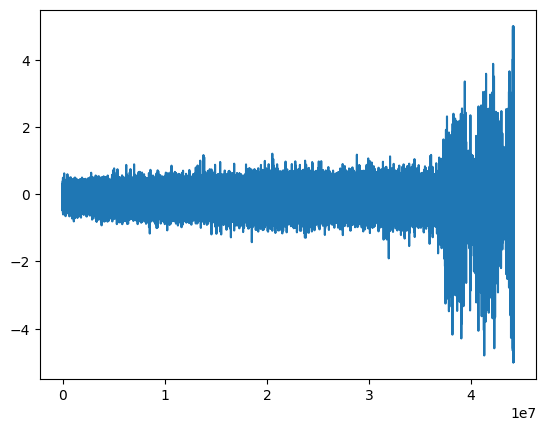

In [151]:
#sanity check
all_data = np.concatenate(experiments_data['1']['bearing3_values'])
#plt.plot(all_data)

#create windows
windows = create_windows(all_data, window_length=640, overlap_length=0, window_type='rectangular')
print("Created %s windows" % len(windows))
#concatenate windows
windows = np.concatenate(windows)
plt.plot(windows)

Wx min: 0, max: 255, mean: 42.809814453125, std: 38.22461641613798
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 36.96630859375, std: 31.621438436532184
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 32.91796875, std: 33.52996283315527
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 45.959716796875, std: 35.961942616002695
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 42.882080078125, std: 36.541346861314516
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 34.2333984375, std: 26.51702389823135
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 32.86962890625, std: 30.35034035439989
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 34.515869140625, std: 31.984626771823926
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 40.1455078125, std: 34.586025833351414
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 35.239013671875, std: 32.529880365677364
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 38.787841796875, std: 33.36940581964596
Wx shape: (64, 64)
Wx min: 0, max: 255, mean: 31.332275390625, std: 24.798429

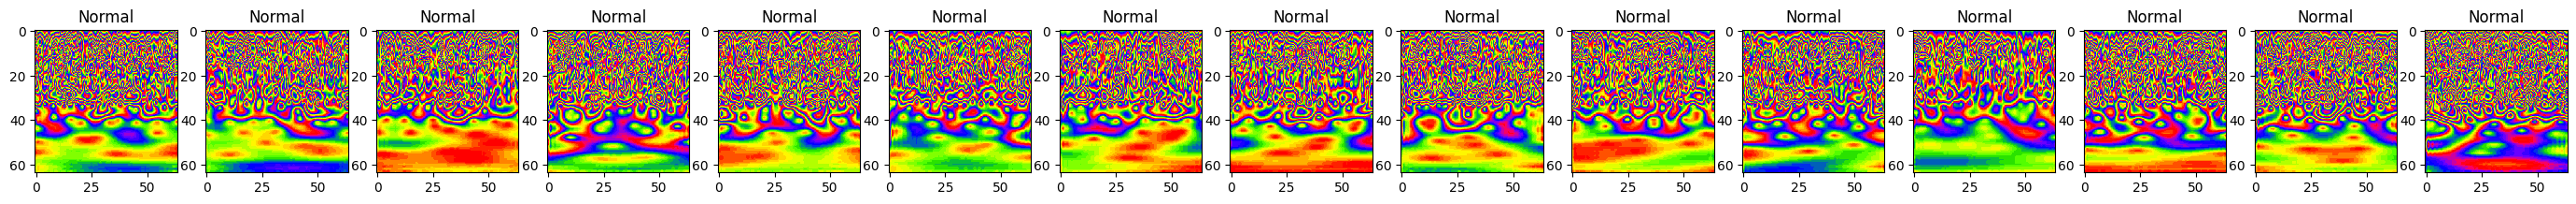

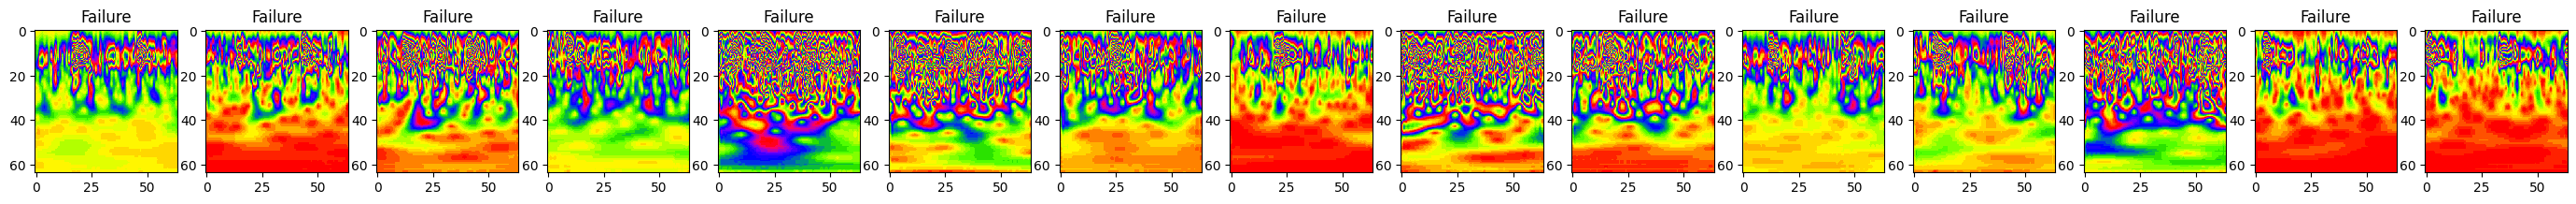

In [173]:
#%%# Define signal ####################################
fail=44100000
ok=0
viz(all_data[ok:], "Normal")
viz(all_data[fail:], "Failure")

### bearing 3 failure labels

from: https://github.com/Miltos-90/Failure_Classification_of_Bearings?tab=readme-ov-file


#### Bearing 3
* early: 2003.10.22.12.06.24 - 2003.11.01.21.41.44
* normal: 2003.11.01.21.51.44 - 2003.11.22.09.16.56
* suspect: 2003.11.22.09.26.56 - 2003.11.25.10.47.32
* Inner race failure: 2003.11.25.10.57.32 - 2003.11.25.23.39.56

startfile: 2003.11.01.21.51.44
endfile: 2003.11.22.09.16.56
Plotting spectrograms
We have 857 spectrograms
startfile: 2003.11.25.10.57.32
endfile: 2003.11.25.23.39.56
Plotting spectrograms
We have 30 spectrograms


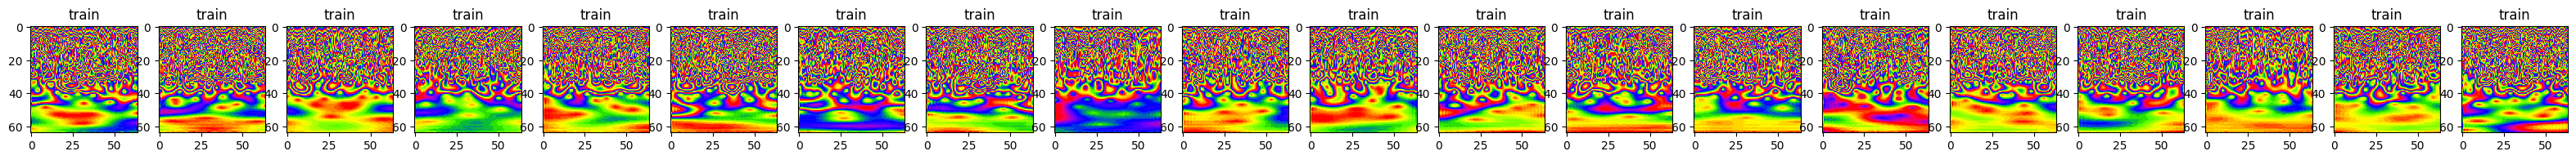

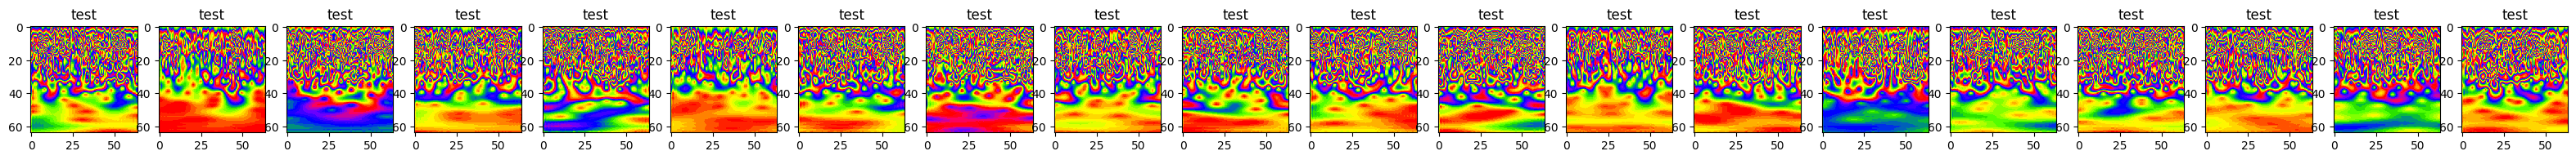

In [175]:
def create_torch_nasa_spectrograms(experiments_data, experiment_files, name="train", startfile = "2003.11.01.21.51.44", endfile= "2003.11.22.09.16.56", bearing=3, experiment="1", save=False, plot=False):

    if startfile.__class__ == str:
        print("startfile: %s" % startfile)
        print("endfile: %s" % endfile)
        index_start = experiments_data[experiment]['bearing%s_keys'%bearing].index(startfile)
        index_end = experiments_data[experiment]['bearing%s_keys'%bearing].index(endfile)
    else:
        index_start = startfile
        index_end = endfile

    training_files = experiment_files[experiment][index_start:index_end]
    training_data = experiments_data[experiment]['bearing%s_values'%bearing][index_start:index_end]
    training_data = np.stack(training_data) #each row is 1 second of data, taken every 10 minutes

    #generate spectrograms
    all_training_sample_spectrograms = []
    for i in range(0, len(training_data)):
        if plot and np.random.rand() > 0.1: 
            #skip 90% of the data if we are plotting
            continue 
        else:
            training_sample_window = create_windows(training_data[i], window_type='regular', window_length=640, overlap_length=0)
        
            for window in training_sample_window:
                if plot and np.random.rand() > 0.2:
                    #skip 90% of the data if we are plotting
                    continue
                else:
                    all_training_sample_spectrograms.append(cwt_features(window))
                    
        

    all_training_sample_spectrograms = np.stack(all_training_sample_spectrograms)

    if save:
        print("we have %s normal training samples of %s x %s stft spectrograms" % (all_training_sample_spectrograms.shape[0], all_training_sample_spectrograms.shape[1], all_training_sample_spectrograms.shape[2]))
        #save the dataset
        torch.save(all_training_sample_spectrograms, "%s_%s_exp%s_b%s_spectrograms.pt" % (DATASET_NAME,name,experiment,bearing))
        os.system("ls")
        
    if plot:
        #create subplot 
        print("Plotting spectrograms")
        print("We have %s spectrograms" % all_training_sample_spectrograms.shape[0])
        plt.figure(figsize=(40, 5))
        for i in range(0, 20):
            plt.subplot(2, 20, i+1)
            plt.title(name)
            plt.imshow(all_training_sample_spectrograms[i],cmap='prism')
            
    return all_training_sample_spectrograms

train = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="train", startfile = "2003.11.01.21.51.44", endfile= "2003.11.22.09.16.56", bearing=3, experiment="1", save=False, plot=True)
test = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="test", startfile = "2003.11.25.10.57.32", endfile= "2003.11.25.23.39.56", bearing=3, experiment="1", save=False, plot=True)

In [177]:
print(train[0].max(), train[0].min(), train[0].mean())
print(test[0].max(), test[0].min(), test[0].mean())


1.0 0.0 0.15939575
1.0 0.0 0.11617461


In [178]:
train = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="train", startfile = "2003.11.01.21.51.44", endfile= "2003.11.22.09.16.56", bearing=3, experiment="1", save=True, plot=False)
test = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="test", startfile = "2003.11.25.10.57.32", endfile= "2003.11.25.23.39.56", bearing=3, experiment="1", save=True, plot=False)

startfile: 2003.11.01.21.51.44
endfile: 2003.11.22.09.16.56
we have 39990 normal training samples of 64 x 64 stft spectrograms
1
1st_test.rar
2
2nd_test.rar
3
3rd_test.rar
ims_bearings_train_exp1_b3_spectrograms.pt
Readme Document for IMS Bearing Data.pdf
startfile: 2003.11.25.10.57.32
endfile: 2003.11.25.23.39.56
we have 1085 normal training samples of 64 x 64 stft spectrograms
1
1st_test.rar
2
2nd_test.rar
3
3rd_test.rar
ims_bearings_test_exp1_b3_spectrograms.pt
ims_bearings_train_exp1_b3_spectrograms.pt
Readme Document for IMS Bearing Data.pdf


1.0 0.0 0.16052228 0.020549389
1.0 0.0 0.11782966 0.0147619415


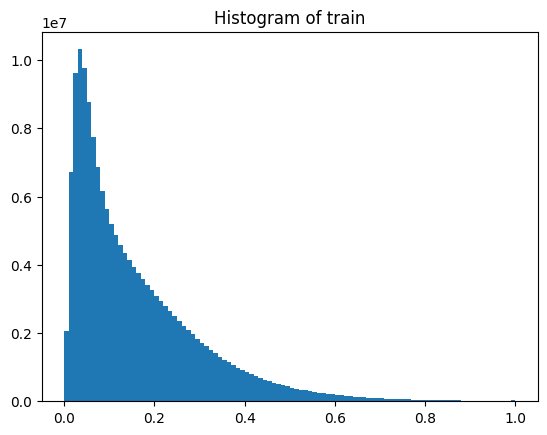

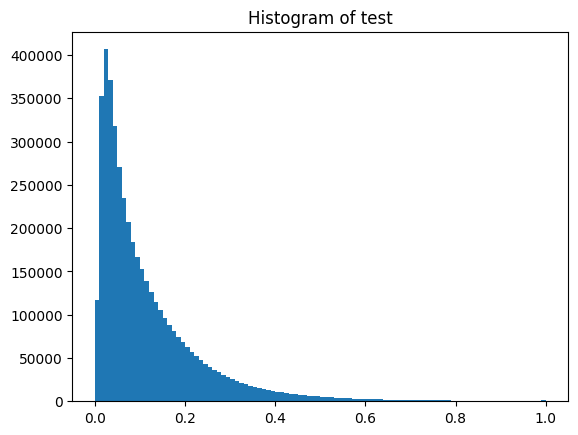

In [206]:
print(train.max(), train.min(), train.mean(), train.var())
print(test.max(), test.min(), test.mean(), test.var())

#histogram of train
plt.hist(train.flatten(), bins=100)
plt.title("Histogram of train")
plt.show()


#histogram of test
plt.hist(test.flatten(), bins=100)
plt.title("Histogram of test")
plt.show()